In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, list them them here
# (e.g. upstream = ['some_task']), otherwise leave as None.
upstream = ["get-presentation-departmental-csmr"]

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
upstream = {"get-presentation-departmental-csmr": {"nb": "/home/lmorales/work/pipelines/epidemiology/epidemiology_pipeline/_products/rates-processing/get-presentation-departmental-csmr.ipynb", "data": "/home/lmorales/work/pipelines/epidemiology/epidemiology_pipeline/_products/rates-processing/presentation-departmental-csmr.csv"}}
product = {"nb": "/home/lmorales/work/pipelines/epidemiology/epidemiology_pipeline/reportes/vis/plot-departmental-rates-in-choropleths.ipynb"}


In [5]:
# your code here...
upstream = {"get-presentation-departmental-csmr": "/home/lmorales/work/pipelines/epidemiology/epidemiology_pipeline/_products/rates-processing/presentation-departmental-csmr.csv"}
product = {"nb": "/home/lmorales/work/pipelines/epidemiology/epidemiology_pipeline/_products/rates-processing/get-departmental-choropleth.ipynb", "data": "/home/lmorales/work/pipelines/epidemiology/epidemiology_pipeline/_products/rates-processing/get-departmental-choropleth.csv"}

# Lectura de datos

In [6]:
import pandas

In [7]:
data = pandas.read_csv(upstream['get-presentation-departmental-csmr'], dtype={'DEPARTAMENTO': object})

In [8]:
data.describe()

,MUERTES_TOTALES,MUERTES_ALZHEIMER,TEA*1000
count,12626.000000,12626.000000,12626.000000
mean,3519.159116,14.453033,3.953510
std,9379.509799,46.202727,14.941524
min,0.000000,0.000000,0.000000
25%,119.000000,0.000000,0.000000
50%,901.500000,2.000000,1.962709
75%,2911.500000,10.000000,5.204945
max,235035.000000,1523.000000,1000.000000


In [9]:
data["RANGO_EDADES"].unique()

array(['0-150', '0-64', '65-150'], dtype=object)

In [10]:
import geopandas

In [11]:
shape_path = "/home/lmorales/work/pipelines/resources/departamentos.geojson"
shape = geopandas.read_file(shape_path)

# reproyectar la capa:
crs_destino = 'EPSG:22185'
# EPSG:22185 (POSGAR 2007 / Argentina 4) es un sistema de coordenadas proyectado específico para Argentina.
shape = shape.to_crs(crs_destino)
shape.head(3)

,departamento_id,departamento_nombre,provincia_id,provincia_nombre,region_name,region_indec,geometry
0,06280,General Alvarado,06,Buenos Aires,Pampas,Centro,"POLYGON ((5679206.775 5789994.650, 5690527.088..."
1,06357,General Pueyrredón,06,Buenos Aires,Pampas,Centro,"POLYGON ((5705074.644 5819871.297, 5718191.646..."
2,06518,Mar Chiquita,06,Buenos Aires,Pampas,Centro,"POLYGON ((5698253.597 5888028.073, 5748544.720..."


In [12]:
df_1997_2017_female = (
    data[
        (data["RANGO_EDADES"] == "65-150")
        & (data["SEXO"] == "female")
        & (data["PERIODO"] == "1997-2017")
    ]
    .reset_index(drop=True)
    .copy()
)

print(df_1997_2017_female.head(2))

     PERIODO RANGO_EDADES    SEXO  REGION     PROVINCIA DEPARTAMENTO  \
0  1997-2017       65-150  female  Centro  Buenos Aires        06007   
1  1997-2017       65-150  female  Centro  Buenos Aires        06014   

      DEPARTAMENTO_NOMBRE  MUERTES_TOTALES  MUERTES_ALZHEIMER   TEA*1000  
0           Adolfo Alsina             1358                 20  14.727541  
1  Adolfo Gonzales Chaves             1112                  9   8.093525  


In [13]:
df_1997_2017_female["DEPARTAMENTO"].value_counts()

DEPARTAMENTO
06007    1
30113    1
54021    1
54014    1
54007    1
        ..
14126    1
14119    1
14112    1
14105    1
94014    1
Name: count, Length: 466, dtype: int64

In [14]:
# Encontrar registros duplicados basados en la columna 'codigo'
duplicados = df_1997_2017_female[df_1997_2017_female.duplicated(subset='DEPARTAMENTO', keep=False)]

# Mostrar registros duplicados
print(duplicados)

Empty DataFrame
Columns: [PERIODO, RANGO_EDADES, SEXO, REGION, PROVINCIA, DEPARTAMENTO, DEPARTAMENTO_NOMBRE, MUERTES_TOTALES, MUERTES_ALZHEIMER, TEA*1000]
Index: []


In [15]:
shape = shape[[col for col in shape.columns if col != "departamento_nombre"]]

In [16]:
columnas_seleccionadas = [
    'PERIODO',
    'RANGO_EDADES',
    'SEXO',
    'PROVINCIA_ID',
    'PROVINCIA_NOMBRE',
    'DEPARTAMENTO_ID',
    'DEPARTAMENTO_NOMBRE',
    'MUERTES_TOTALES',
    'MUERTES_ALZHEIMER',
    'TEA*1000',
    'GEOMETRY',
    'LATITUD',
    'LONGITUD'
]

In [17]:
import matplotlib.pyplot as plt

In [18]:
df_1997_2017_female = (
    data[
        (data["RANGO_EDADES"] == "65-150")
        & (data["SEXO"] == "female")
        & (data["PERIODO"] == "1997-2017")
    ]
    .reset_index(drop=True)
    .copy()
)

print(df_1997_2017_female.head(2))

print(df_1997_2017_female["DEPARTAMENTO"].value_counts()[:5])

# Encontrar registros duplicados basados en la columna 'codigo'
duplicados = df_1997_2017_female[df_1997_2017_female.duplicated(subset='DEPARTAMENTO', keep=False)]

# Mostrar registros duplicados
print("duplicados:")
print(duplicados)

# Realizar la combinación (merge)
shape_female_plus64_1997_2017_df = pandas.merge(
    shape,
    df_1997_2017_female,
    left_on="departamento_id",
    right_on="DEPARTAMENTO",
    how='left',
    indicator=True)

# Identificar y contar los códigos en df1 que no fueron encontrados en df2
codigos_no_encontrados = shape_female_plus64_1997_2017_df[shape_female_plus64_1997_2017_df['_merge'] == 'left_only']['departamento_id']

# Mostrar los códigos no encontrados y la cantidad
print(f"Cantidad de departamentos sin datos: {codigos_no_encontrados.nunique()}")

shape_female_plus64_1997_2017_df.columns = [col.upper() for col in shape_female_plus64_1997_2017_df.columns]

columnas_seleccionadas = [
    'PROVINCIA_ID',
    'PROVINCIA_NOMBRE',
    'DEPARTAMENTO_ID', 'DEPARTAMENTO_NOMBRE',
    'GEOMETRY', 'PERIODO', 'RANGO_EDADES', 'SEXO',
    'MUERTES_TOTALES', 'MUERTES_ALZHEIMER', 'TEA*1000']

shape_female_plus64_1997_2017_df = shape_female_plus64_1997_2017_df[columnas_seleccionadas].copy()


shape_female_plus64_1997_2017_df['PERIODO'] = '1997-2017'
shape_female_plus64_1997_2017_df['RANGO_EDADES'] = '>64'
shape_female_plus64_1997_2017_df['SEXO'] = 'mujeres'
shape_female_plus64_1997_2017_df['MUERTES_TOTALES'] = shape_female_plus64_1997_2017_df['MUERTES_TOTALES'].fillna(0)
shape_female_plus64_1997_2017_df['MUERTES_ALZHEIMER'] = shape_female_plus64_1997_2017_df['MUERTES_ALZHEIMER'].fillna(0)
shape_female_plus64_1997_2017_df['TEA*1000'] = shape_female_plus64_1997_2017_df['TEA*1000'].fillna(0)

shape_female_plus64_1997_2017_df['LATITUD'] = shape_female_plus64_1997_2017_df['GEOMETRY'].centroid.y
shape_female_plus64_1997_2017_df['LONGITUD'] = shape_female_plus64_1997_2017_df['GEOMETRY'].centroid.x

shape_female_plus64_1997_2017_df = shape_female_plus64_1997_2017_df.set_geometry('GEOMETRY')

shape_female_plus64_1997_2017_df = (
    shape_female_plus64_1997_2017_df
        .sort_values(by=["PROVINCIA_NOMBRE", "DEPARTAMENTO_ID"])
        .reset_index(drop=True)
)

     PERIODO RANGO_EDADES    SEXO  REGION     PROVINCIA DEPARTAMENTO  \
0  1997-2017       65-150  female  Centro  Buenos Aires        06007   
1  1997-2017       65-150  female  Centro  Buenos Aires        06014   

      DEPARTAMENTO_NOMBRE  MUERTES_TOTALES  MUERTES_ALZHEIMER   TEA*1000  
0           Adolfo Alsina             1358                 20  14.727541  
1  Adolfo Gonzales Chaves             1112                  9   8.093525  
DEPARTAMENTO
06007    1
30113    1
54021    1
54014    1
54007    1
Name: count, dtype: int64
duplicados:
Empty DataFrame
Columns: [PERIODO, RANGO_EDADES, SEXO, REGION, PROVINCIA, DEPARTAMENTO, DEPARTAMENTO_NOMBRE, MUERTES_TOTALES, MUERTES_ALZHEIMER, TEA*1000]
Index: []
Cantidad de departamentos sin datos: 65


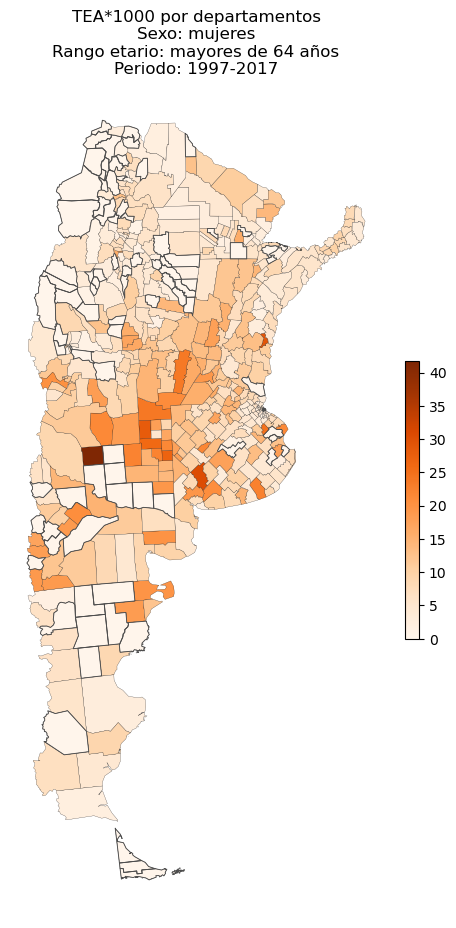

In [19]:
f, ax = plt.subplots(figsize=(6, 12))

shape_female_plus64_1997_2017_df.plot(
    column="TEA*1000",
    ax=ax,
    legend=True,
    cmap="Oranges",
    edgecolor="#000000",
    linewidth=.15,
    legend_kwds={'shrink': 0.3}
)

shape_female_plus64_1997_2017_df[shape_female_plus64_1997_2017_df["MUERTES_ALZHEIMER"] == 0].plot(
    ax=ax,
    color='None',
    edgecolor="#4d4d4d",
    linewidth=.65,

)

ax.set_axis_off()

ax.set_title("""TEA*1000 por departamentos
Sexo: mujeres
Rango etario: mayores de 64 años
Periodo: 1997-2017""")

plt.show();

In [20]:
df_1997_2017_male = (
    data[
        (data["RANGO_EDADES"] == "65-150")
        & (data["SEXO"] == "male")
        & (data["PERIODO"] == "1997-2017")
    ]
    .reset_index(drop=True)
    .copy()
)

print(df_1997_2017_male.head(2))

print(df_1997_2017_male["DEPARTAMENTO"].value_counts()[:5])

# Encontrar registros duplicados basados en la columna 'codigo'
duplicados = df_1997_2017_male[df_1997_2017_male.duplicated(subset='DEPARTAMENTO', keep=False)]

# Mostrar registros duplicados
print("duplicados:")
print(duplicados)

# Realizar la combinación (merge)
shape_male_plus64_1997_2017_df = pandas.merge(
    shape,
    df_1997_2017_male,
    left_on="departamento_id",
    right_on="DEPARTAMENTO",
    how='left',
    indicator=True)

# Identificar y contar los códigos en df1 que no fueron encontrados en df2
codigos_no_encontrados = shape_male_plus64_1997_2017_df[shape_male_plus64_1997_2017_df['_merge'] == 'left_only']['departamento_id']

# Mostrar los códigos no encontrados y la cantidad
print(f"Cantidad de departamentos sin datos: {codigos_no_encontrados.nunique()}")

shape_male_plus64_1997_2017_df.columns = [col.upper() for col in shape_male_plus64_1997_2017_df.columns]

columnas_seleccionadas = [
    'PROVINCIA_ID',
    'PROVINCIA_NOMBRE',
    'DEPARTAMENTO_ID', 'DEPARTAMENTO_NOMBRE',
    'GEOMETRY', 'PERIODO', 'RANGO_EDADES', 'SEXO',
    'MUERTES_TOTALES', 'MUERTES_ALZHEIMER', 'TEA*1000']

shape_male_plus64_1997_2017_df = shape_male_plus64_1997_2017_df[columnas_seleccionadas].copy()


shape_male_plus64_1997_2017_df['PERIODO'] = '1997-2017'
shape_male_plus64_1997_2017_df['RANGO_EDADES'] = '>64'
shape_male_plus64_1997_2017_df['SEXO'] = 'mujeres'
shape_male_plus64_1997_2017_df['MUERTES_TOTALES'] = shape_male_plus64_1997_2017_df['MUERTES_TOTALES'].fillna(0)
shape_male_plus64_1997_2017_df['MUERTES_ALZHEIMER'] = shape_male_plus64_1997_2017_df['MUERTES_ALZHEIMER'].fillna(0)
shape_male_plus64_1997_2017_df['TEA*1000'] = shape_male_plus64_1997_2017_df['TEA*1000'].fillna(0)

shape_male_plus64_1997_2017_df['LATITUD'] = shape_male_plus64_1997_2017_df['GEOMETRY'].centroid.y
shape_male_plus64_1997_2017_df['LONGITUD'] = shape_male_plus64_1997_2017_df['GEOMETRY'].centroid.x

shape_male_plus64_1997_2017_df = shape_male_plus64_1997_2017_df.set_geometry('GEOMETRY')

shape_male_plus64_1997_2017_df = (
    shape_male_plus64_1997_2017_df
        .sort_values(by=["PROVINCIA_NOMBRE", "DEPARTAMENTO_ID"])
        .reset_index(drop=True)
)

     PERIODO RANGO_EDADES  SEXO  REGION     PROVINCIA DEPARTAMENTO  \
0  1997-2017       65-150  male  Centro  Buenos Aires        06007   
1  1997-2017       65-150  male  Centro  Buenos Aires        06014   

      DEPARTAMENTO_NOMBRE  MUERTES_TOTALES  MUERTES_ALZHEIMER  TEA*1000  
0           Adolfo Alsina             1451                 10  6.891799  
1  Adolfo Gonzales Chaves             1059                  7  6.610009  
DEPARTAMENTO
06007    1
30113    1
54021    1
54014    1
54007    1
Name: count, dtype: int64
duplicados:
Empty DataFrame
Columns: [PERIODO, RANGO_EDADES, SEXO, REGION, PROVINCIA, DEPARTAMENTO, DEPARTAMENTO_NOMBRE, MUERTES_TOTALES, MUERTES_ALZHEIMER, TEA*1000]
Index: []
Cantidad de departamentos sin datos: 65


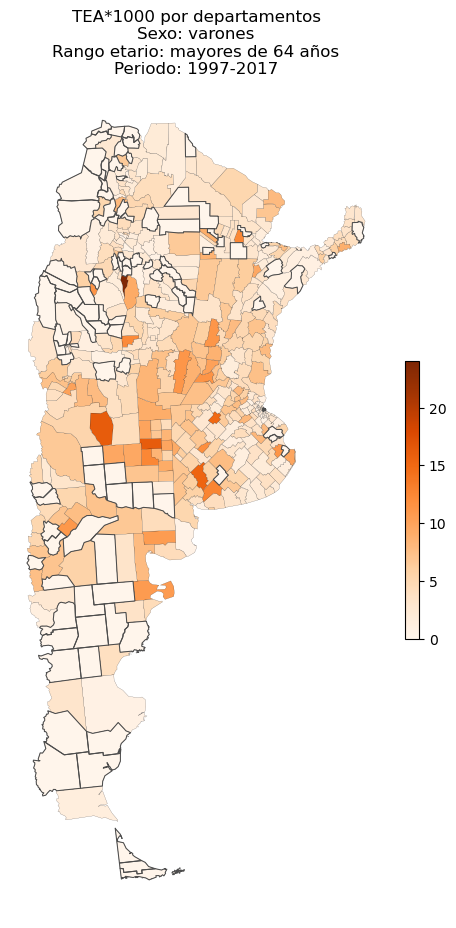

In [21]:
f, ax = plt.subplots(figsize=(6, 12))

shape_male_plus64_1997_2017_df.plot(
    column="TEA*1000",
    ax=ax,
    legend=True,
    cmap="Oranges",
    edgecolor="#000000",
    linewidth=.1,
    legend_kwds={'shrink': 0.3}
)

shape_male_plus64_1997_2017_df[shape_male_plus64_1997_2017_df["MUERTES_ALZHEIMER"] == 0].plot(
    ax=ax,
    color='None',
    edgecolor="#4d4d4d",
    linewidth=.75,

)

ax.set_axis_off()

ax.set_title("""TEA*1000 por departamentos
Sexo: varones
Rango etario: mayores de 64 años
Periodo: 1997-2017""")

plt.show();

In [22]:
df_1997_2017_all = (
    data[
        (data["RANGO_EDADES"] == "65-150")
        & (data["SEXO"] == "all")
        & (data["PERIODO"] == "1997-2017")
    ]
    .reset_index(drop=True)
    .copy()
)

print(df_1997_2017_all.head(2))

print(df_1997_2017_all["DEPARTAMENTO"].value_counts()[:5])

# Encontrar registros duplicados basados en la columna 'codigo'
duplicados = df_1997_2017_all[df_1997_2017_all.duplicated(subset='DEPARTAMENTO', keep=False)]

# Mostrar registros duplicados
print("duplicados:")
print(duplicados)

# Realizar la combinación (merge)
shape_plus64_1997_2017_df = pandas.merge(
    shape,
    df_1997_2017_all,
    left_on="departamento_id",
    right_on="DEPARTAMENTO",
    how='left',
    indicator=True)

# Identificar y contar los códigos en df1 que no fueron encontrados en df2
codigos_no_encontrados = shape_plus64_1997_2017_df[shape_plus64_1997_2017_df['_merge'] == 'left_only']['departamento_id']

# Mostrar los códigos no encontrados y la cantidad
print(f"Cantidad de departamentos sin datos: {codigos_no_encontrados.nunique()}")

shape_plus64_1997_2017_df.columns = [col.upper() for col in shape_plus64_1997_2017_df.columns]

columnas_seleccionadas = [
    'PROVINCIA_ID',
    'PROVINCIA_NOMBRE',
    'DEPARTAMENTO_ID', 'DEPARTAMENTO_NOMBRE',
    'GEOMETRY', 'PERIODO', 'RANGO_EDADES', 'SEXO',
    'MUERTES_TOTALES', 'MUERTES_ALZHEIMER', 'TEA*1000']

shape_plus64_1997_2017_df = shape_plus64_1997_2017_df[columnas_seleccionadas].copy()


shape_plus64_1997_2017_df['PERIODO'] = '1997-2017'
shape_plus64_1997_2017_df['RANGO_EDADES'] = '>64'
shape_plus64_1997_2017_df['SEXO'] = 'mujeres'
shape_plus64_1997_2017_df['MUERTES_TOTALES'] = shape_plus64_1997_2017_df['MUERTES_TOTALES'].fillna(0)
shape_plus64_1997_2017_df['MUERTES_ALZHEIMER'] = shape_plus64_1997_2017_df['MUERTES_ALZHEIMER'].fillna(0)
shape_plus64_1997_2017_df['TEA*1000'] = shape_plus64_1997_2017_df['TEA*1000'].fillna(0)

shape_plus64_1997_2017_df['LATITUD'] = shape_plus64_1997_2017_df['GEOMETRY'].centroid.y
shape_plus64_1997_2017_df['LONGITUD'] = shape_plus64_1997_2017_df['GEOMETRY'].centroid.x

shape_plus64_1997_2017_df = shape_plus64_1997_2017_df.set_geometry('GEOMETRY')

shape_plus64_1997_2017_df = (
    shape_plus64_1997_2017_df
        .sort_values(by=["PROVINCIA_NOMBRE", "DEPARTAMENTO_ID"])
        .reset_index(drop=True)
)

     PERIODO RANGO_EDADES SEXO  REGION     PROVINCIA DEPARTAMENTO  \
0  1997-2017       65-150  all  Centro  Buenos Aires        06007   
1  1997-2017       65-150  all  Centro  Buenos Aires        06014   

      DEPARTAMENTO_NOMBRE  MUERTES_TOTALES  MUERTES_ALZHEIMER   TEA*1000  
0           Adolfo Alsina             2813                 30  10.664771  
1  Adolfo Gonzales Chaves             2173                 16   7.363092  
DEPARTAMENTO
06007    1
30113    1
54021    1
54014    1
54007    1
Name: count, dtype: int64
duplicados:
Empty DataFrame
Columns: [PERIODO, RANGO_EDADES, SEXO, REGION, PROVINCIA, DEPARTAMENTO, DEPARTAMENTO_NOMBRE, MUERTES_TOTALES, MUERTES_ALZHEIMER, TEA*1000]
Index: []
Cantidad de departamentos sin datos: 65


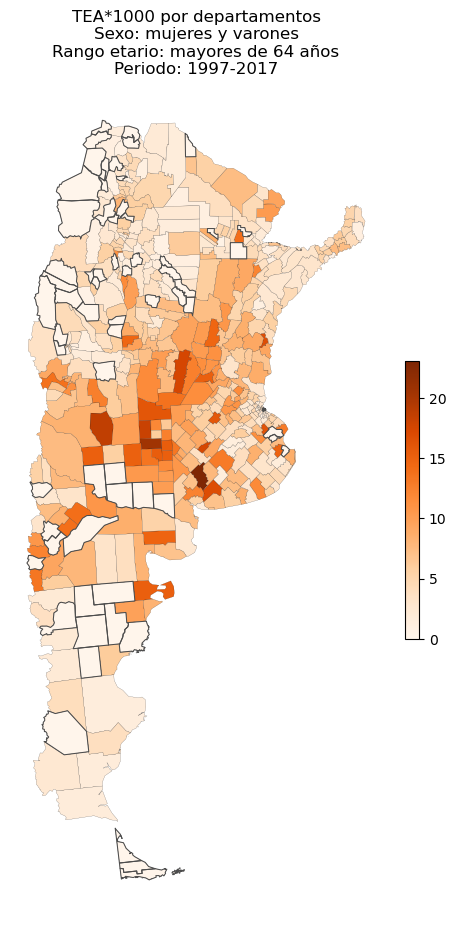

In [23]:
f, ax = plt.subplots(figsize=(6, 12))

shape_plus64_1997_2017_df.plot(
    column="TEA*1000",
    ax=ax,
    legend=True,
    cmap="Oranges",
    edgecolor="#000000",
    linewidth=.1,
    legend_kwds={'shrink': 0.3}
)

shape_plus64_1997_2017_df[shape_plus64_1997_2017_df["MUERTES_ALZHEIMER"] == 0].plot(
    ax=ax,
    color='None',
    edgecolor="#4d4d4d",
    linewidth=.75,
)

ax.set_axis_off()

ax.set_title("""TEA*1000 por departamentos
Sexo: mujeres y varones
Rango etario: mayores de 64 años
Periodo: 1997-2017""")

plt.show();

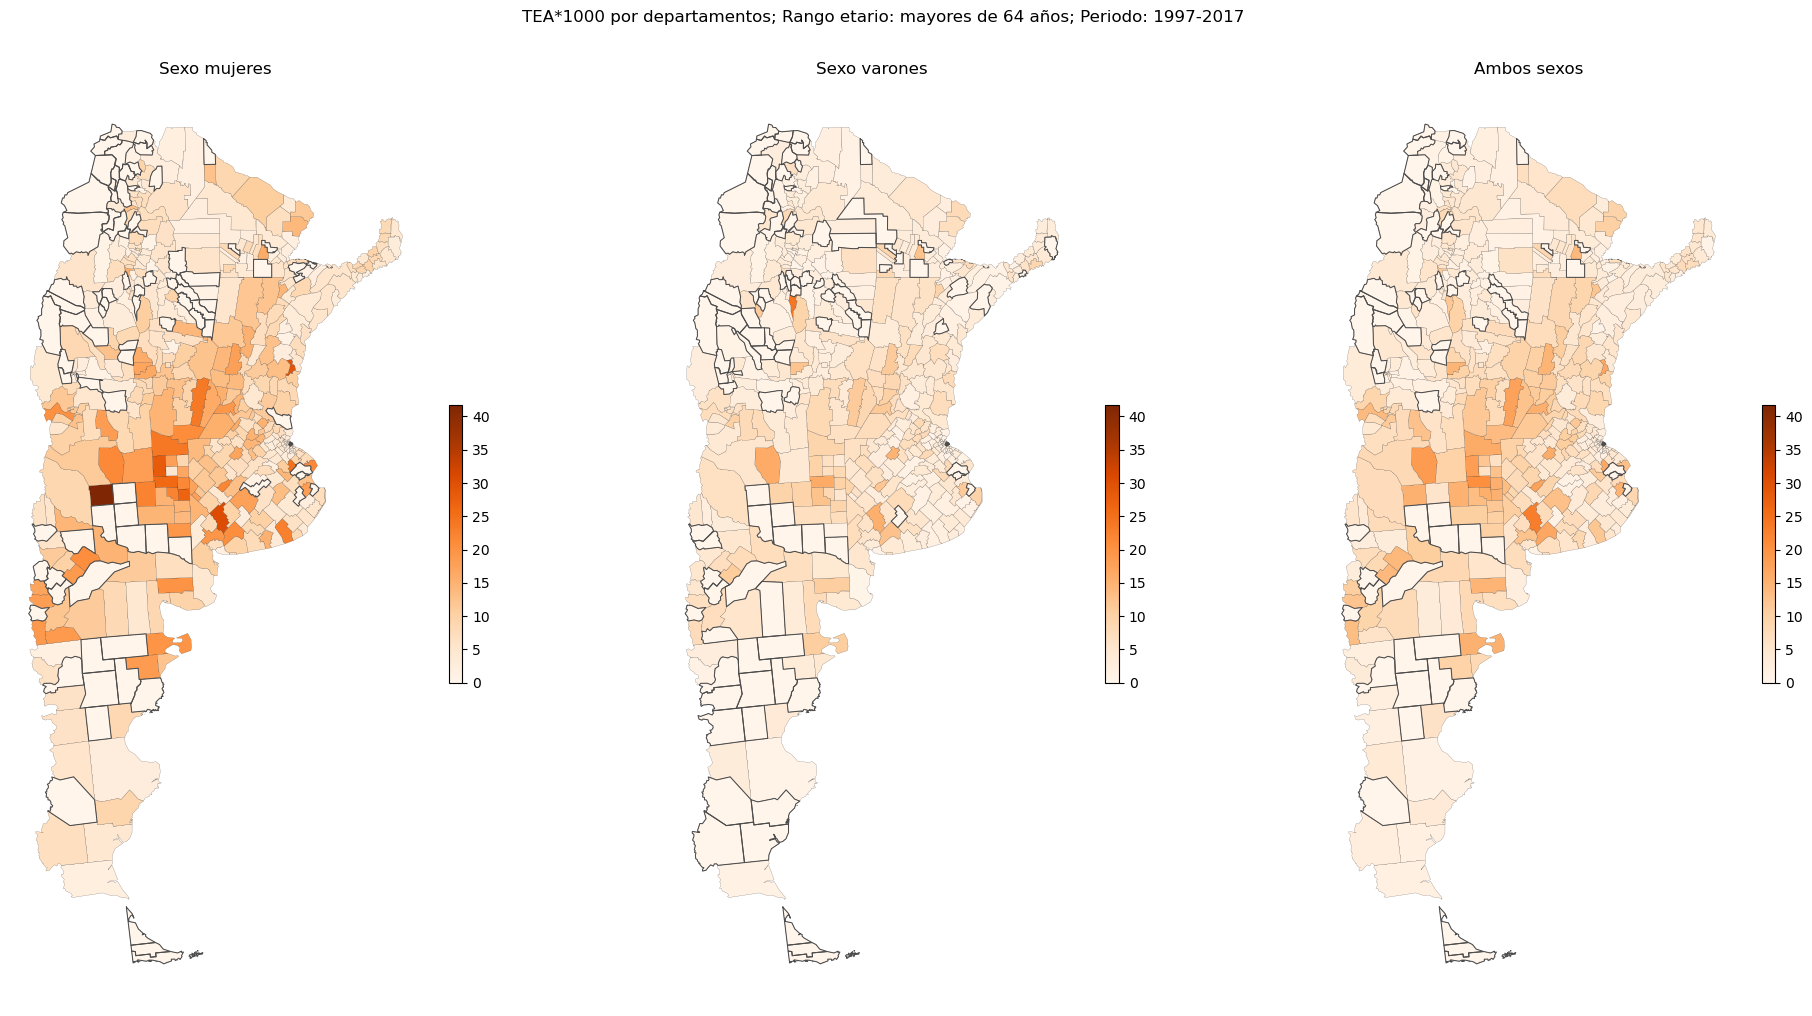

In [24]:
f, ax = plt.subplots(ncols=3, nrows=1, figsize=(24, 12))

shapes = [
    shape_female_plus64_1997_2017_df,
    shape_male_plus64_1997_2017_df,
    shape_plus64_1997_2017_df
]


VMAX = max([
    shape_plus64_1997_2017_df["TEA*1000"].max(),
    shape_female_plus64_1997_2017_df["TEA*1000"].max(),
    shape_male_plus64_1997_2017_df["TEA*1000"].max(),
])

titles = [
    "Sexo mujeres",
    "Sexo varones",
    "Ambos sexos",
]
axes = ax.flatten()

for ax, shape, title in zip(axes, shapes, titles):
    shape.plot(
        column="TEA*1000",
        ax=ax,
        legend=True,
        cmap="Oranges",
        edgecolor="#000000",
        linewidth=.1,
        legend_kwds={'shrink': 0.3},
        vmin=0,
        vmax=VMAX
    )

    shape[shape["MUERTES_ALZHEIMER"] == 0].plot(
        ax=ax,
        color='None',
        edgecolor="#4d4d4d",
        linewidth=.75,
    )

    ax.set_axis_off()

    ax.set_title(title)

plt.suptitle(
    """TEA*1000 por departamentos; Rango etario: mayores de 64 años; Periodo: 1997-2017""",
    ha="center",
    y=.94
)

plt.show();

In [25]:
print(VMAX)

41.66666666666666
